In [ ]:
### Purpose: Calculate if block skipping is frame conserving - Figure S3
### Input: block_exons.csv from script 3

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import re

In [12]:
df = pd.read_csv('block_exons_ddPSImax0.2_adjacent.moreSKIPPED.csv')

In [17]:
# Convert Coord column to extract exon lengths
def extract_length(coord):
    match = re.search(r'chr\d+:(\d+)-(\d+)', coord)
    if match:
        start, end = map(int, match.groups())
        return abs(end - start + 1)
    return 0

df['exon_length'] = df['Coord'].apply(extract_length)

# Sorting and grouping by gene_name and exon_number
df = df.sort_values(by=['gene_name', 'exon_number']).reset_index(drop=True)

# Finding adjacent exons
df['next_exon_diff'] = df.groupby('gene_name')['exon_number'].diff(-1).abs()
df['prev_exon_diff'] = df.groupby('gene_name')['exon_number'].diff(1).abs()
df['has_neighbor'] = ((df['next_exon_diff'] == 1) | (df['prev_exon_diff'] == 1)).astype(int)

df_filtered = df[df['has_neighbor'] == 1].reset_index(drop=True)

# Clustering exons by dPSI threshold
proximity_threshold = 0.02
def create_subgroups(group):
    group = group.sort_values(by='dPSI').reset_index(drop=True)
    subgroups = []
    current_group = [group.iloc[0]]
    for i in range(1, len(group)):
        if abs(group.iloc[i]['dPSI'] - group.iloc[i-1]['dPSI']) <= proximity_threshold:
            current_group.append(group.iloc[i])
        else:
            subgroups.append(current_group)
            current_group = [group.iloc[i]]
    subgroups.append(current_group)
    return subgroups

subgroups = df_filtered.groupby('gene_name').apply(create_subgroups).explode().dropna()



/var/folders/s5/012b_sqx2bl9vk20cyklfj_r0000gn/T/ipykernel_50950/4152986883.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subgroups = df_filtered.groupby('gene_name').apply(create_subgroups).explode().dropna()


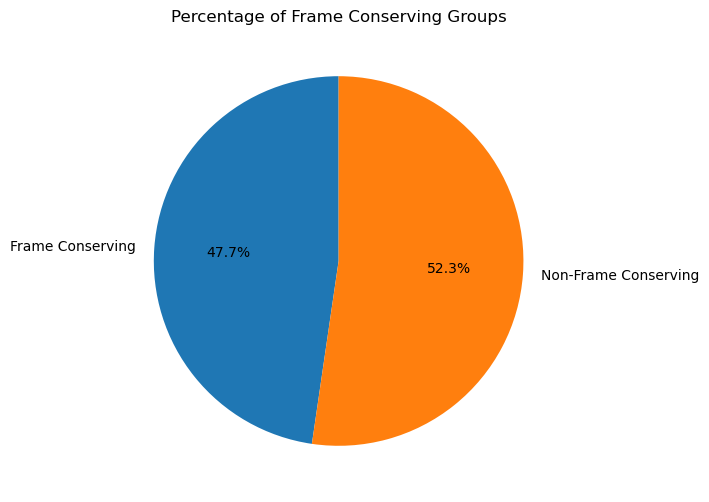

In [20]:
# Compute sum of exon lengths and check divisibility by 3
frame_conserving = []
for group in subgroups:
    total_length = sum(exon['exon_length'] for exon in group)
    frame_conserving.append(total_length % 3 == 0)

# Plotting
labels = ['Frame Conserving', 'Non-Frame Conserving']
values = [sum(frame_conserving), len(frame_conserving) - sum(frame_conserving)]
plt.figure(figsize=(6,6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Frame Conserving Groups')
plt.savefig('frame_conserving_exon_block_skipping.pdf')
plt.show()
